# HLSL30 Search and Composite

Authors: Nathan Thomas (GSFC/UMD), Sumant Jha (MSFC/USRA), Aimee Barciauskas (Development Seed), Alex Mandel (Development Seed)

Date: December 19, 2022

Description: In this tutorial, we will search the LPDAAC for Harmonized Landsat Sentinel-2 (HLS) 30m optical imagery that intersects an AOI. We will filter the catalog based on a cloud cover % and build a maximum-NDVI (Normalized Difference Vegetation Index) composite image, including a suite of popular indices, which will help give us an in-depth look at vegetation health.

## Run This Notebook
To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.

## About the Data
Harmonized Landsat Sentinel-2 30m 

Harmonized Landsat Sentinel-2 (HLS) was developed in response to a greater need for moderate-to-high resolution imagery to track various short-term landcover changes. Data are gathered by the Landsat-8 and Landsat-9 satellites, which carry the Operational Land Imager (OLI), as well as the Sentinel-2A and Sentinel-2B satellites, which carry the Multi-Spectral Instrument (MSI). With combined measurements from both the Landsat and Sentinel satellites, HLS imagery has global coverage with a spatial resolution of 30m and a temporal resolution of 2-3 days. (Source: [HLS Overview Page](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/))

Note about HLS datasets: The Sentinel and Landsat assets have been "harmonized" in the sense that these products have been generated to use the same spatial resolution and grid system. Thus, the HLS S30 and L30 products can be used interchangeably in algorithms and are "stackable". However, the individual band assets are specific to each provider.

## Additional Resources
- [HLSL30 v002 Dataset Landing Page](https://lpdaac.usgs.gov/products/hlsl30v002/)
- [Landsat 8 Bands and Combinations Blog](https://www.l3harrisgeospatial.com/Learn/Blogs/Blog-Details/ArtMID/10198/ArticleID/15691/The-Many-Band-Combinations-of-Landsat-8)
- [HLSS30 v002 Dataset Landing Page](https://lpdaac.usgs.gov/products/hlss30v002/)
- [Sentinel 2 Bands and Combinations Blog](https://gisgeography.com/sentinel-2-bands-combinations/)
- [Harmonized Landsat Sentinel-2 (HLS) User Guide](https://lpdaac.usgs.gov/documents/1326/HLS_User_Guide_V2.pdf)

## Importing and Installing Packages

We will begin by installing any packages we need and importing the packages that we will use.

If needed the following packages should be installed:

In [1]:
# cleanup data: removes data files that should be replaced
!rm -rf ./local-s3.json
!rm -rf ./sample.json

if False:
    !conda install -c conda-forge pystac-client -y
    !conda install -c conda-forge rio-tiler -y

**Prerequisites** 

* geopandas
* folium
* pystac-client
* rio_tiler

In [ ]:
# Uncomment the following lines to install these packages if you haven't already.
# !pip install geopandas
# !pip install folium
# !pip install pystac-client
# !pip install rio_tiler

We will now import a suite of packages that we will need:

In [3]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.maap-project.org')
import geopandas as gpd
import folium
import h5py
import pandas
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pystac_client import Client
import datetime
import os
import rasterio as rio
import boto3
import json
import botocore
from rasterio.session import AWSSession
from rio_tiler.io import COGReader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Creating an AOI

To begin we will create a polygon in a forested area in Virginia, USA. We will do this by providing a number of lat/lon coordinates and creating an AOI.

In [4]:
lon_coords = [-80, -80, -79., -79, -80]
lat_coords = [39, 38.2, 38.2, 39, 39]

polygon_geom = Polygon(zip(lon_coords, lat_coords))
crs = 'epsg:4326'
AOI = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
AOI_bbox = AOI.bounds.iloc[0].to_list()

We can visualize this polygon using a folium interactive map.

In [ ]:
m = folium.Map([38.5,-79.3], zoom_start=9, tiles='OpenStreetMap')
folium.GeoJson(AOI).add_to(m)
folium.LatLngPopup().add_to(m)
m

![Example folium map-output with polygon](hls_polygon_maap.png "Folium map with polygon")

## Accessing the HLS Data

To be able to access the HLS imagery we need to activate a 'rasterio' AWS session. This will give us the required access keys that we need to search and read data from the LPDAAC S3 bucket.

In [6]:
def get_aws_session_DAAC():
    """Create a Rasterio AWS Session with Credentials"""
    creds = maap.aws.earthdata_s3_credentials('https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials')
    boto3_session = boto3.Session(
        aws_access_key_id=creds['accessKeyId'], 
        aws_secret_access_key=creds['secretAccessKey'],
        aws_session_token=creds['sessionToken'],
        region_name='us-west-2'
    )
    return AWSSession(boto3_session)

In [7]:
print('Getting AWS credentials...')
aws_session = get_aws_session_DAAC()
print('Finished')

Getting AWS credentials...
Finished


Now that we have our session credentials set up, we can search the HLS catalog using the following function, filtering by spatial extent (our AOI) and a time window:

In [8]:
def query_stac(year, bbox, max_cloud, api, start_month_day, end_month_day):
    print('opening client')
    catalog = Client.open(api)
    
    date_min = str(year) + '-' + start_month_day
    print('start_month_day:\t\t', start_month_day)
    print('end_month_day:\t\t', end_month_day)
    date_max = str(year) + '-' + end_month_day
    start_date = datetime.datetime.strptime(date_min, "%Y-%m-%d")
    end_date = datetime.datetime.strptime(date_max, "%Y-%m-%d") 
    start = start_date.strftime("%Y-%m-%dT00:00:00Z")
    end = end_date.strftime("%Y-%m-%dT23:59:59Z")
    
    print('start date, end date:\t\t', start, end)
    
    print('\nConducting HLS search now...')
    
    search = catalog.search(
        collections=["HLSL30.v2.0"],
        datetime=[start,end],
        bbox=bbox,
        max_items=500, # for testing, and keep it from hanging
        # query={"eo:cloud_cover":{"lt":20}} #doesn't work
    )
    print(f"Search query parameters:\n{search}\n")
    results = search.get_all_items_as_dict()

    return results
    

Here we run our STAC search and write the results out to a JSON file so we can access it later.

In [9]:
search = query_stac(2020, AOI_bbox, 20, 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', '06-01', '09-30')

with open("./sample.json", "w") as outfile:
    json.dump(search, outfile)

opening client
start_month_day:		 06-01
end_month_day:		 09-30
start date, end date:		 2020-06-01T00:00:00Z 2020-09-30T23:59:59Z

Conducting HLS search now...
Search query parameters:



So far, we have not filtered by cloud cover, which is a common filtering parameter for optical imagery. We can use the metadata files included in our STAC search to find the amount of cloud cover in each file and decide if it meets our threshold or not. We will set a cloud cover threshold of 50%. While we are doing this, we will also change the URLs to access the optical imagery from \"https://\" to AWS S3 URLs (\"S3://\").

In [10]:
def write_local_data_and_catalog_s3(catalog, bands, save_path, cloud_cover, s3_path="s3://"):
    '''Given path to a response json from a sat-api query, make a copy changing urls to local paths'''
    creds = maap.aws.earthdata_s3_credentials('https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials')
    aws_session = boto3.session.Session(
        aws_access_key_id=creds['accessKeyId'], 
        aws_secret_access_key=creds['secretAccessKey'],
        aws_session_token=creds['sessionToken'],
        region_name='us-west-2')
    s3 = aws_session.client('s3')
    
    with open(catalog) as f:
        clean_features = []
        asset_catalog = json.load(f)
   
        # Remove duplicate scenes
        features = asset_catalog['features']
        
        for feature in features:
            umm_json = feature['links'][6]['href']
            umm_data = !curl -i {umm_json}
            for line in umm_data:
                if "CLOUD_COVERAGE" in line:
                    cc_perc = (int(line.split("CLOUD_COVERAGE")[-1].split('"')[4]))
                    if cc_perc > cloud_cover:
                        pass
                    else:
                        try:
                            for band in bands:
                                output_file = feature['assets'][band]['href'].replace('https://data.lpdaac.earthdatacloud.nasa.gov/', s3_path)
                                bucket_name = output_file.split("/")[2]
                                s3_key = "/".join(output_file.split("/")[3:])
                                head = s3.head_object(Bucket = bucket_name, Key = s3_key, RequestPayer='requester')
                                if head['ResponseMetadata']['HTTPStatusCode'] == 200:
                                    feature['assets'][band]['href'] = output_file
                            clean_features.append(feature)
                        except botocore.exceptions.ClientError as e:
                            if e.response['Error']['Code'] == "404":
                                print(f"The object does not exist. {output_file}")
                            else:
                                raise
        # save and updated catalog with local paths
        asset_catalog['features'] = clean_features
        local_catalog = catalog.replace('sample', 'local-s3')
        with open(local_catalog,'w') as jsonfile:
            json.dump(asset_catalog, jsonfile)
        
        return local_catalog

When run, this will create a new JSON file that will only include files that meet our cloud cover threshold and have S3 URLs.

In [11]:
local_cat = write_local_data_and_catalog_s3('./sample.json', ['B02','B03','B04','B05','B06','B07','Fmask'], './', 60, s3_path="s3://")

Now that we have images that meet our requirements, we will composite them into a multiband image for our AOI. We will composite the image on a band-by-band basis, so we first have to get a list of all the file paths for each band.

In [12]:
def GetBandLists(inJSON, bandnum, tiles=['']):
    bands = dict({2:'B02', 3:'B03', 4:'B04', 5:'B05', 6:'B06', 7:'B07',8:'Fmask'})
    BandList = []
    with open(inJSON) as f:
        response = json.load(f)
    for i in range(len(response['features'])):
        try:
            getBand = response['features'][i]['assets'][bands[bandnum]]['href']
            # check 's3' is at position [:2]
            if getBand.startswith('s3', 0, 2):
                BandList.append(getBand)
        except Exception as e:
            print(e)
                
    BandList.sort()
    return BandList

We will build a band list of file paths for each image band. We will also access the 'fmask' band to mask out clouds.

In [13]:
blue_bands = GetBandLists('./local-s3.json', 2)
green_bands = GetBandLists('./local-s3.json', 3)
red_bands = GetBandLists('./local-s3.json', 4)
nir_bands = GetBandLists('./local-s3.json', 5)
swir_bands = GetBandLists('./local-s3.json', 6)
swir2_bands = GetBandLists('./local-s3.json', 7)
fmask_bands = GetBandLists('./local-s3.json', 8)

print('number of each images in each band = ', len(blue_bands))

number of each images in each band =  21


## Reading in HLS Data and Creating Composite

We will not read all of the HLS data, as we only need what's included in our AOI. To do this "windowed read" we need to know the dimensions, in pixels, of the window. To do this we need to convert our AOI to a projected coordinate system (UTM) and calculate the number of columns and rows we will need, using a pixel resolution of 30m.

In [14]:
def get_shape(bbox, res=30):
    left, bottom, right, top = bbox
    width = int((right-left)/res)
    height = int((top-bottom)/res)

    return height,width

# convert to m
AOI_utm = AOI.to_crs('epsg:32617')
height, width = get_shape(AOI_utm.bounds.iloc[0].to_list())


When building a maximum-NDVI composite, the first data we need is the red and NIR bands to make an NDVI band for each image. We will use 'riotiler' to perform a windowed read of our data. We will also read the 'fmask' layer as we can use this to mask out unwanted pixels.

In [15]:
def ReadData(file, in_bbox, height, width, epsg="epsg:4326", dst_crs="epsg:4326"):
    '''Read a window of data from the raster matching the tile bbox''' 
    with COGReader(file) as cog:
        img = cog.part(in_bbox, bounds_crs=epsg, max_size=None, dst_crs=dst_crs, height=height, width=width)
    
    return (np.squeeze(img.as_masked().astype(np.float32)) * 0.0001)

Our AWS session has an expiry time. Now would be a good time to renew our access key to ensure we do not encounter any timeout issues.

In [16]:
print('Getting AWS credentials...')
aws_session = get_aws_session_DAAC()
print('Finished')

Getting AWS credentials...
Finished


Using our renewed session, for each band we will read in the relevant band in each of our images, creating an array of image bands.

In [17]:
with rio.Env(aws_session):
    print('reading red bands...')
    red_stack = np.array([ReadData(red_bands[i], AOI_bbox, height, width, epsg="epsg:4326", dst_crs="epsg:4326") for i in range(len(red_bands))])
    print('reading nir bands...')
    nir_stack = np.array([ReadData(nir_bands[i], AOI_bbox, height, width, epsg="epsg:4326", dst_crs="epsg:4326") for i in range(len(nir_bands))])
    print('reading fmask bands...')
    fmask_stack = np.array([ReadData(fmask_bands[i], AOI_bbox, height, width, epsg="epsg:4326", dst_crs="epsg:4326") for i in range(len(fmask_bands))])
    print('finished')
    
print("number of red_bands = ", np.shape(red_stack)[0])


reading red bands...
reading nir bands...
reading fmask bands...
finished
number of red_bands =  21


Now that we have our red band array and NIR band array we can make an NDVI image. While we do this, we will also apply our 'fmask' to remove any pixels that contain clouds.

In [18]:
ndvi_stack =  np.ma.array(np.where(((fmask_stack==1)), -9999, (nir_stack-red_stack)/(nir_stack+red_stack)))
ndvi_stack = np.where((~np.isfinite(ndvi_stack)) | (ndvi_stack>1), -9999, ndvi_stack)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


At this point, we can plot our images and see which ones contain cloud coverage. These images have gaps where there is no data or cloud coverage.

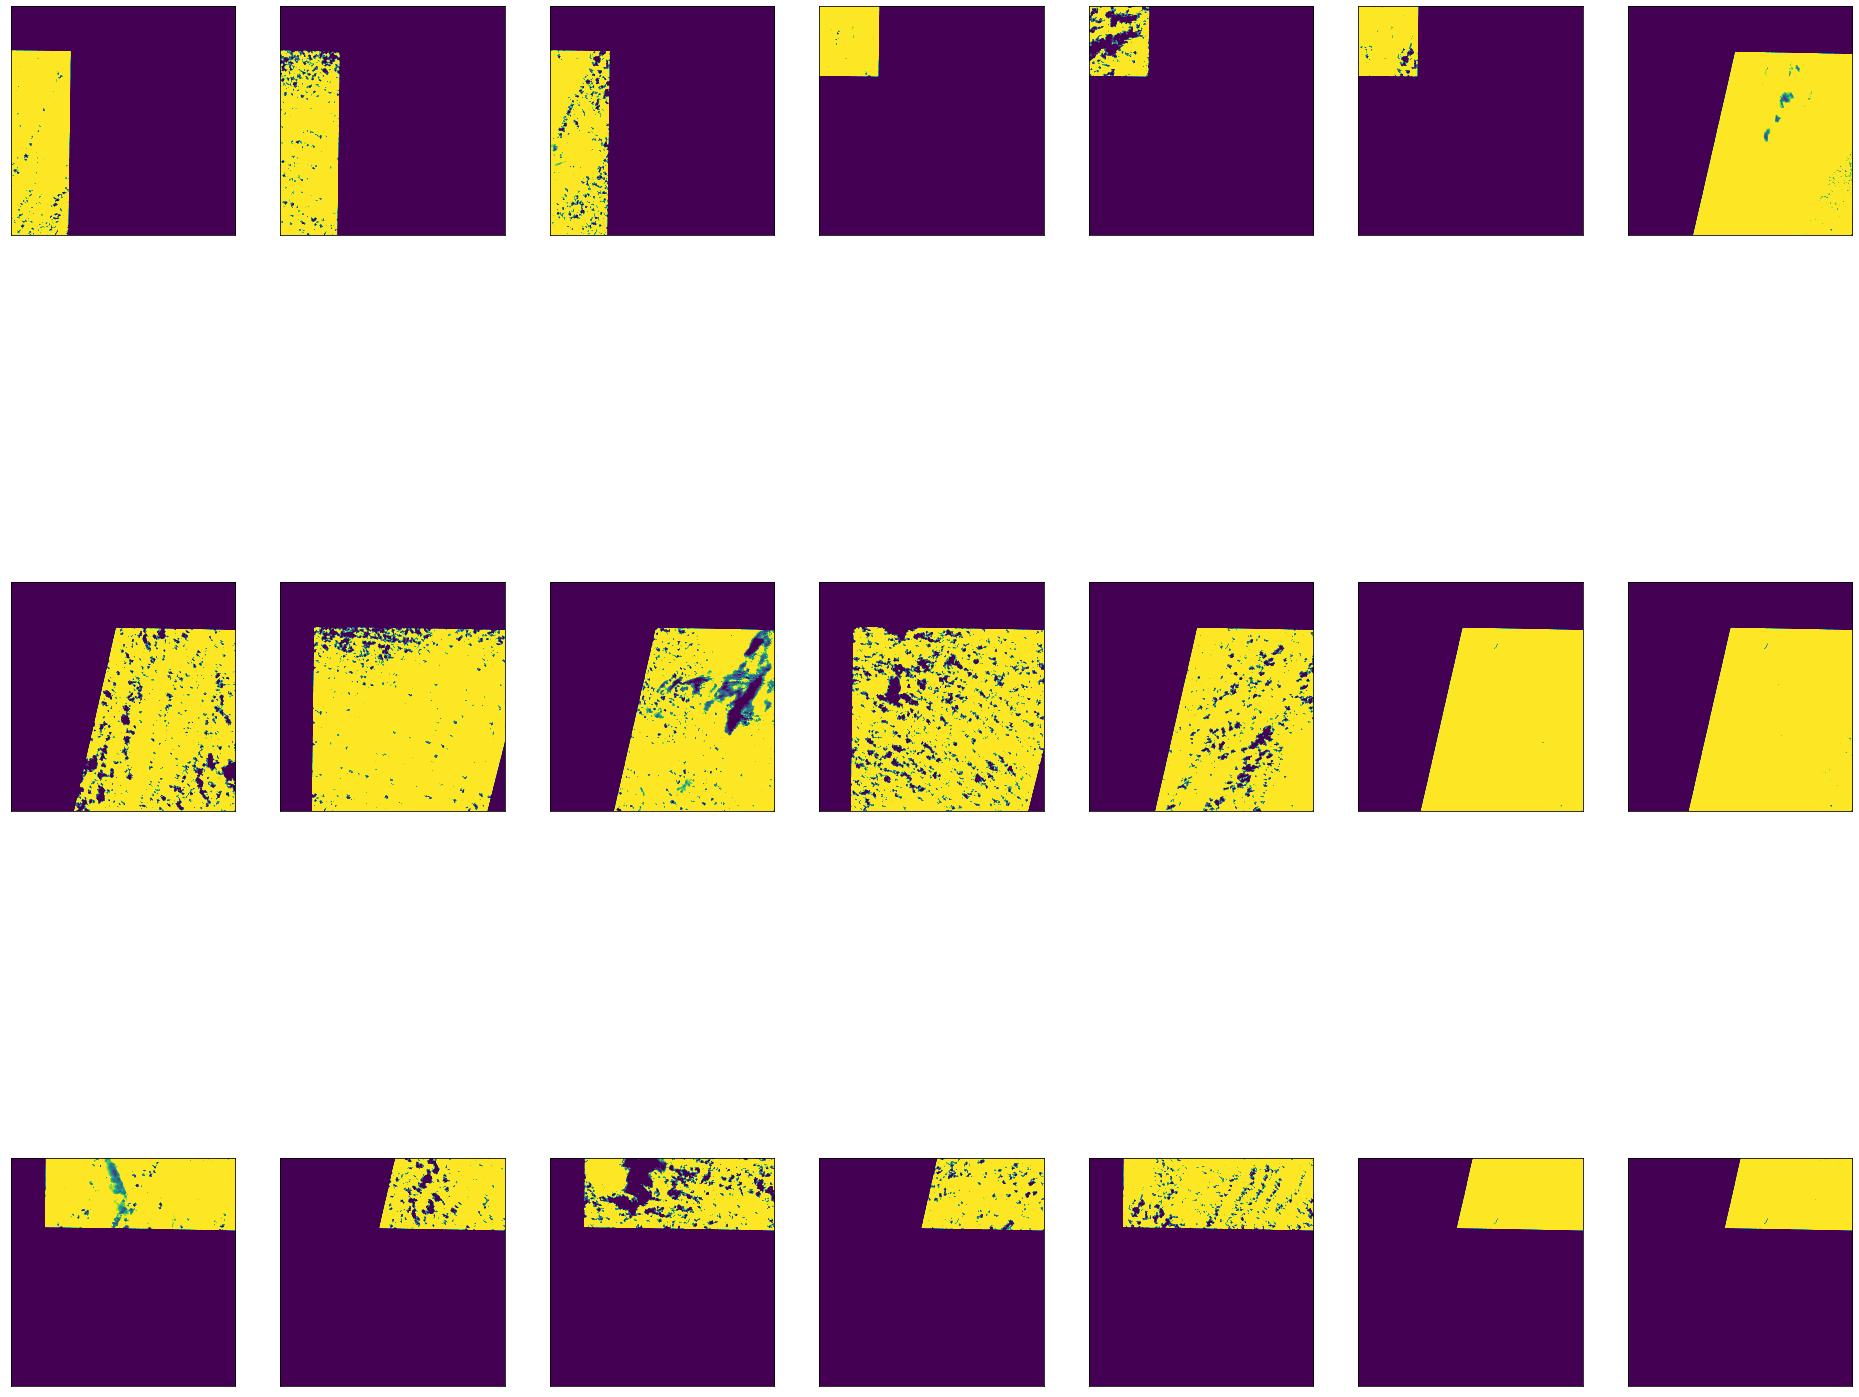

In [19]:
fig, axes = plt.subplots(3,7, figsize=(33,30))

for i, ax in enumerate(axes.flat):
    ndvi_stack[i] = np.where((ndvi_stack[i]>1) | (ndvi_stack[i]<-1), 0, ndvi_stack[i])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.imshow(ndvi_stack[i], cmap='viridis', clim=(0.1, 0.5))

Now that we have a stack of NDVI bands, we can create an index band that maps the pixel position from each band where the NDVI value is greatest. We can use this to locate the pixels we want to use in our composite.

In [20]:
# Create Bool mask where there is no value in any of the NDVI layers
print("Make NDVI valid mask")
print("shape:\t\t", np.ma.array(ndvi_stack).shape)
MaxNDVI = np.ma.max(np.ma.array(ndvi_stack),axis=0)
BoolMask = np.ma.getmask(MaxNDVI)
del MaxNDVI

## Get the argmax index positions from the stack of NDVI images
print("Get stack nan mask")
ndvi_stack = np.ma.array(ndvi_stack)
print("Calculate Stack max NDVI image")
NDVImax = np.nanargmax(ndvi_stack,axis=0)
## create a tmp array (binary mask) of the same input shape
NDVItmp = np.ma.zeros(ndvi_stack.shape, dtype=bool)

## for each dimension assign the index position (flattens the array to a LUT)
print("Create LUT of max NDVI positions")
for i in range(np.shape(ndvi_stack)[0]):
    NDVItmp[i,:,:]=NDVImax==i


Make NDVI valid mask
shape:		 (21, 3006, 2951)
Get stack nan mask
Calculate Stack max NDVI image
Create LUT of max NDVI positions


Now that we have our NDVI lookup table and a list of all the images for each band, we can make composites based on the maximum NDVI value. For this, we will use the following two functions:

In [21]:
def CollapseBands(inArr, NDVItmp, BoolMask):
    inArr = np.ma.masked_equal(inArr, 0)
    inArr[np.logical_not(NDVItmp)]=0 
    compImg = np.ma.masked_array(inArr.sum(0), BoolMask)
    #print(compImg)
    return compImg

def CreateComposite(file_list, NDVItmp, BoolMask, in_bbox, height, width, epsg, dst_crs):
    MaskedFile = [ReadData(file_list[i], in_bbox, height, width, epsg, dst_crs) for i in range(len(file_list))]
    Composite=CollapseBands(MaskedFile, NDVItmp, BoolMask)
    return Composite

For each band, we will read all the images (for the required band) and create a composite based on the maximum NDVI value.

In [22]:
aws_session = get_aws_session_DAAC() 
with rio.Env(aws_session):
    print('Creating Blue Composite')
    blue_comp = CreateComposite(blue_bands, NDVItmp, BoolMask, AOI_bbox, height, width, "epsg:4326", "epsg:4326")
    print('Creating Green Composite')
    green_comp = CreateComposite(green_bands, NDVItmp, BoolMask, AOI_bbox, height, width, "epsg:4326", "epsg:4326")
    print('Creating Red Composite')
    red_comp = CreateComposite(red_bands, NDVItmp, BoolMask, AOI_bbox, height, width, "epsg:4326", "epsg:4326")
    print('Creating NIR Composite')
    nir_comp = CreateComposite(nir_bands, NDVItmp, BoolMask, AOI_bbox, height, width, "epsg:4326", "epsg:4326")
    print('Creating SWIR Composite')
    swir_comp = CreateComposite(swir_bands, NDVItmp, BoolMask, AOI_bbox, height, width, "epsg:4326", "epsg:4326")
    print('Creating SWIR2 Composite')
    swir2_comp = CreateComposite(swir2_bands, NDVItmp, BoolMask, AOI_bbox, height, width, "epsg:4326", "epsg:4326")
    print('Creating NDVI Composite')
    ndvi_comp = CollapseBands(ndvi_stack, NDVItmp, BoolMask)
    print('Creating fmask Composite')
    fmask_comp = CollapseBands(fmask_stack, NDVItmp, BoolMask)


Creating Blue Composite
Creating Green Composite
Creating Red Composite
Creating NIR Composite
Creating SWIR Composite
Creating SWIR2 Composite
Creating NDVI Composite
Creating fmask Composite


We can look at our NDVI composite image and see we now have a complete image for our AOI.

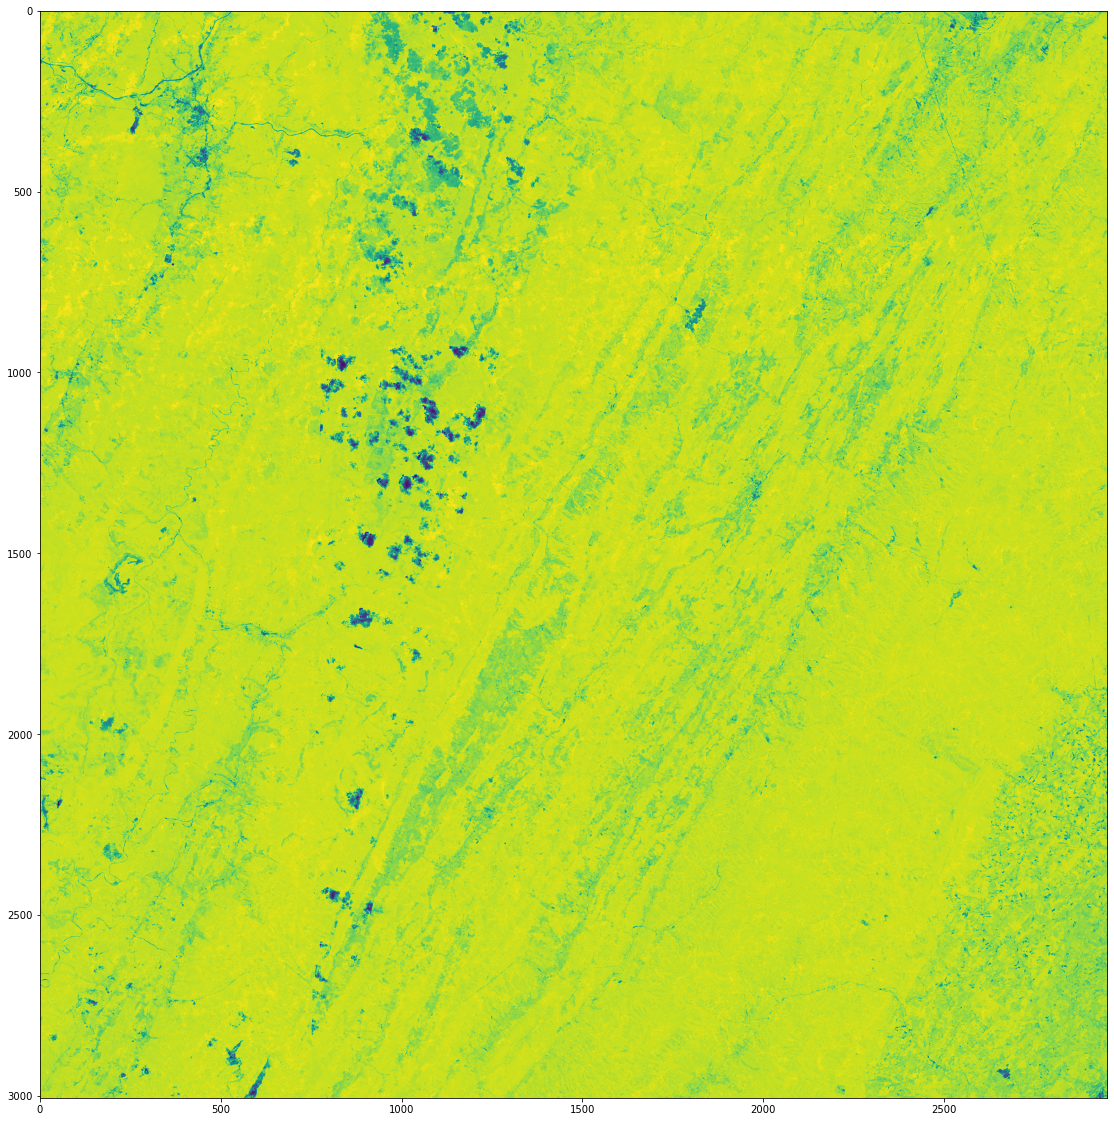

In [23]:
fig, axes = plt.subplots(1,1, figsize=(20,20))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.imshow(np.where(fmask_comp==1, -9999, ndvi_comp))

Now that we have a 7-band composite image, we can use these bands to calculate a suite of common vegetation indices using the following functions. These indices will give us a better look at vegetation health by giving us information on vegetation water content, greenness, and more.


In [24]:
# SAVI
def calcSAVI(red, nir):
    savi = ((nir - red)/(nir + red + 0.5))*(1.5)
    print('\tSAVI Created')
    return savi

# NDMI
def calcNDMI(nir, swir):
    ndmi = (nir - swir)/(nir + swir)
    print('\tNDMI Created')
    return ndmi

# EVI
def calcEVI(blue, red, nir):
    evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1))
    print('\tEVI Created')
    return evi

# NBR
def calcNBR(nir, swir2):
    nbr = (nir - swir2)/(nir + swir2)
    print('\tNBR Created')
    return nbr

# MSAVI
def calcMSAVI(red, nir):
    msavi = (2 * nir + 1 - np.sqrt((2 * nir + 1)**2 - 8 * (nir - red))) / 2
    print('\tMSAVI Created')
    return msavi

We can call these functions and make our additional indices.

In [25]:
# calculate covars
print("Generating covariates")
SAVI = calcSAVI(red_comp, nir_comp)
#print("NDMI")
NDMI = calcNDMI(nir_comp, swir_comp)
#print("EVI")
EVI = calcEVI(blue_comp, red_comp, nir_comp)
#print("NBR")
NBR = calcNBR(nir_comp, swir2_comp)
MSAVI = calcMSAVI(red_comp, nir_comp)

Generating covariates
	SAVI Created
	NDMI Created
	EVI Created
	NBR Created
	MSAVI Created


We have a suite of 12 bands now, and we can merge them together into a single 12-band image stack.

In [26]:
print("\nCreating raster stack...\n")
stack = np.transpose([blue_comp, green_comp, red_comp, nir_comp, swir_comp, swir2_comp, ndvi_comp, SAVI, MSAVI, NDMI, EVI, NBR], [0, 1, 2])
stack = np.where(fmask_comp==1, -9999, stack)
print(np.shape(stack))


Creating raster stack...

(12, 3006, 2951)


## Display Results

We can look at each of these bands by using 'matplotlib' to plot each one individually.

In [ ]:
n: int = len(stack)
#topo_cmaps = ["bone","Spectral", "magma", "RdBu", "coolwarm"]
topo_cmaps = ['Blues','Greens','Reds','PuRd','OrRd','BuPu','YlGn','GnBu','YlOrBr','inferno','plasma', 'viridis']
print(stack.shape)
bandnames = ['blue_comp', 'green_comp', 'red_comp', 'nir_comp', 'swir_comp', 'swir2_comp', 'ndvi_comp', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'NBR']

font = {'size'   : 30}
matplotlib.rc('font', **font)

#axs = [[0,0],[0,1],[0,2],[0,3],[0,4],[0,5],[1,0],[1,1],[1,2],[1,3],[1,4],[1,5],[2,0],[2,1],[2,2],[2,3],[2,4],[2,5]]  
fig, axes = plt.subplots(3,4, figsize=(33,30))
print(axes.flat)
for i, ax in enumerate(axes.flat):
    ax.imshow(stack[i], cmap=topo_cmaps[i], clim=(np.percentile(stack[i], 10), np.percentile(stack[i], 90)))
    ax.set_title(bandnames[i])


![Example output grid](hls_image_grid.png "<numpy.flatiter object at 0x561c7d6fe260>")

We can also visualize our composite NDVI band on our interactive 'folium' map. You can see that even though we found multiple images, by using a windowed read we were able to just read and process the data we needed.

In [ ]:
m = folium.Map(location=[38.6, -78.5], zoom_start=9, tiles='CartoDB positron')
AOI_bx = AOI.bounds
#folium.GeoJson(AOI, style_function=lambda x: {'fillColor': 'orange','opacity':0}).add_to(m)
geo_r = folium.raster_layers.ImageOverlay(np.ma.getdata(ndvi_comp), opacity=1, bounds=[[AOI_bx['miny'][0],AOI_bx['minx'][0]],[AOI_bx['maxy'][0],AOI_bx['maxx'][0]]])
geo_r.add_to(m)

m

![Example folium map-output](hls_map_nvdi_composite.png "Folium map")